In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.__version__

'2.3.0'

# Load Data

In [2]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers", 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    as_supervised=True, 
    with_info=True
)

In [3]:
print(metadata.splits["train"].num_examples)
num_classes = metadata.features["label"].num_classes
print(num_classes)

3670
5


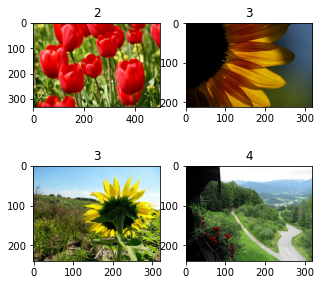

In [4]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5,5))
for i, ex in enumerate(tfds.as_numpy(samples)):    
    np_image , label =ex
    ax = fig.add_subplot(2,2, i + 1)
    ax.set_title(label)
    ax.imshow(np_image)
plt.show()

# Convolutions

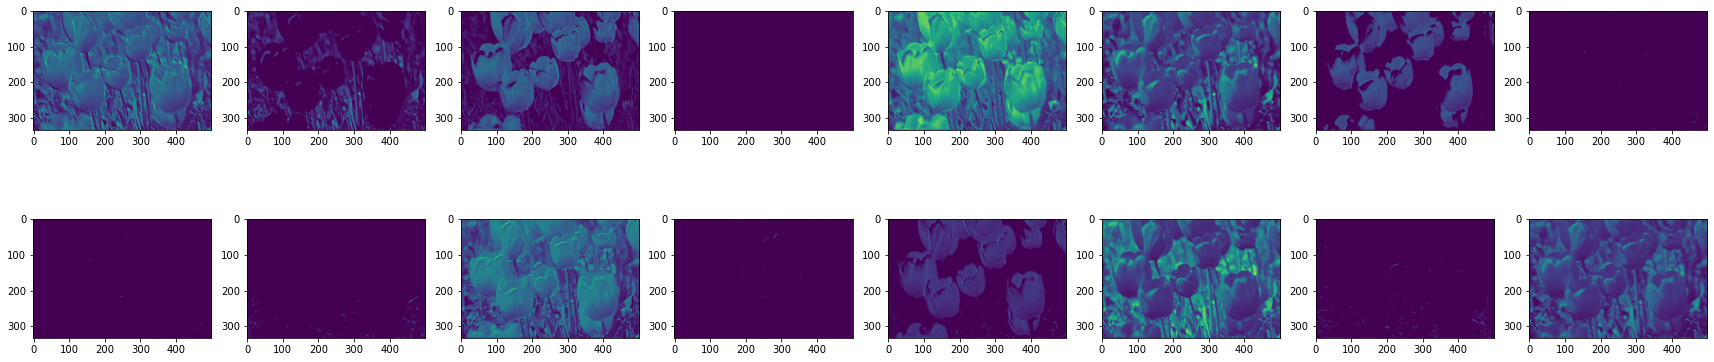

In [5]:
samples = ds_train.take(1)
for i, ex in enumerate(samples):
    image, label = ex
    tf_image = tf.expand_dims(image,0) / 255      
    features_maps = layers.Conv2D(16,3, padding="same", activation="relu")(tf_image)
    fig = plt.figure(figsize=(30,30))
    features_maps = features_maps.numpy().squeeze()
    for i, fmap in enumerate(np.rollaxis(features_maps, -1)):
        ax = fig.add_subplot(8,8, i + 1)        
        ax.imshow(fmap, vmin=np.min(fmap), vmax=np.max(fmap))
    plt.show()

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
])

AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds,batch_size=32, shuffle=False, augment=False):
  # Resize and rescale the images
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)
  # create batches
  ds = ds.batch(batch_size)
  
  # apply data augmentation in case that is required
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

resized_train_ds = prepare(ds_train, shuffle=True, augment=True)
resized_val_ds = prepare(ds_validation)
resized_test_ds = prepare(ds_test)

# Create Model

In [7]:

model = Sequential([  
  #data_augmentation,
  #layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(50, 50, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
#model.build(input_shape = (None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)       

In [9]:
epochs=20
history = model.fit(resized_train_ds,validation_data=resized_val_ds, epochs=epochs)

Epoch 1/20
92/92 [==============================] - 27s 289ms/step - loss: 1.2337 - accuracy: 0.4850 - val_loss: 1.0548 - val_accuracy: 0.5831
Epoch 2/20
92/92 [==============================] - 26s 286ms/step - loss: 1.0223 - accuracy: 0.5923 - val_loss: 1.3413 - val_accuracy: 0.4550
Epoch 3/20
92/92 [==============================] - 26s 287ms/step - loss: 0.9537 - accuracy: 0.6117 - val_loss: 0.8996 - val_accuracy: 0.6703
Epoch 4/20
92/92 [==============================] - 27s 290ms/step - loss: 0.8719 - accuracy: 0.6604 - val_loss: 0.9262 - val_accuracy: 0.6676
Epoch 5/20
92/92 [==============================] - 27s 293ms/step - loss: 0.8367 - accuracy: 0.6761 - val_loss: 0.9229 - val_accuracy: 0.6594
Epoch 6/20
92/92 [==============================] - 27s 291ms/step - loss: 0.8114 - accuracy: 0.6870 - val_loss: 0.8502 - val_accuracy: 0.6703
Epoch 7/20
92/92 [==============================] - 27s 292ms/step - loss: 0.7655 - accuracy: 0.6996 - val_loss: 0.8417 - val_accuracy: 0.6921

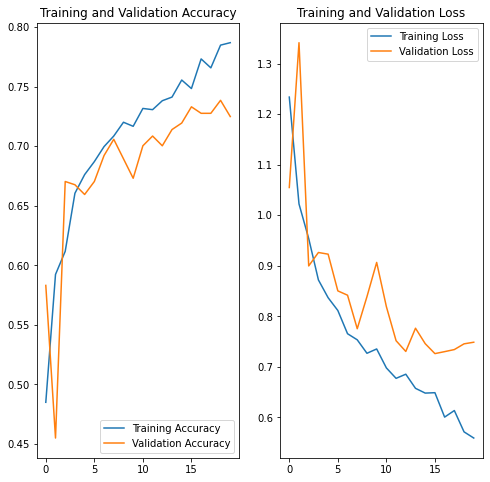

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('out')
loaded_model = tf.keras.models.load_model('out')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: out/assets
INFO:tensorflow:Assets written to: out/assets


This image most likely belongs to sunflowers with a 100.00 percent confidence.


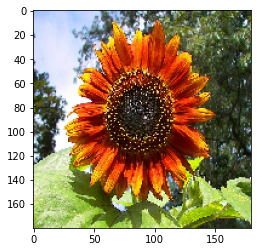

In [12]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_tensor = tf.expand_dims(img_array, 0) # Create a batch
predictions = loaded_model.predict(img_tensor)
score = tf.nn.softmax(predictions[0])
class_names = metadata.features['label'].names
print( "This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[np.argmax(score)], 100 * np.max(score)))
plt.imshow(img_array.astype(np.uint8))
plt.show()

# Convert to tfjs

In [13]:
# pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "out")